## Advanced Lane Finding

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

### Calibration

#### 1. Compute the camera calibration matrix and distortion coefficients given a set of chessboard images

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pickle
%matplotlib inline

In [2]:
def calc_calibration_points(images, n_x, n_y):
    '''
    This function takes a series of chessboard images taken with the camera for which the calibration points are
    to be calculated. The number of chessboard corners in x and y direction must be counted manually and passed
    to the function as well. "Chessboard corners" are only points where two black and two white squares 
    intersect.
    The function returns all recognized chessboard corners in the following way:
    object_points: a list of 3D points corresponding to the location of the corners in real world coordinates
    image_points: a list of 2D points corresponding to the location of the corners in image space
    '''
    # Prepare object points, like (0,0,0), (1,0,0), (2,0,0), ...
    object_points_current = np.zeros((n_x*n_y, 3), np.float32)
    object_points_current[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1, 2)

    # Arrays to store object points and image points from all the images
    object_points = [] # 3d points (enumeration of the corners) in real world space
    image_points = [] # 2d points in image plane

    # Step through the list and search for chessboard corners
    for idx, fname in enumerate(images):
        image = cv2.imread(fname)
        image_grayscale = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(image_grayscale, (n_x,n_y), None)

        # If found, add object points, image points
        if ret == True:
            object_points.append(object_points_current)
            image_points.append(corners)

            # Draw and display the corners
            cv2.drawChessboardCorners(image, (n_x,n_y), corners, ret)
            write_name = 'camera_cal/corners_found' + str(idx) + '.jpg'
            cv2.imwrite(write_name, image)
            cv2.imshow('Image', image)
            cv2.waitKey(500)

    cv2.destroyAllWindows()
    
    return object_points, image_points

# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')

# Counted chessboard corners
n_x = 9
n_y = 6

# Get object_points and image_points for calibration
object_points, image_points = calc_calibration_points(images, n_x, n_y)

# Read in image used for calibration
image = cv2.imread('camera_cal/calibration3.jpg')
image_size = (image.shape[1], image.shape[0])

# Calibrate camera given object_points and image_points
# Function returns reprojection error, camera matrix, distortion coefficients, rotation and translation 
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(object_points, image_points, image_size, None, None)
    
# Save camera calibration result for later use
dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist
pickle.dump(dist_pickle, open("camera_cal/dist_pickle.p", "wb"))

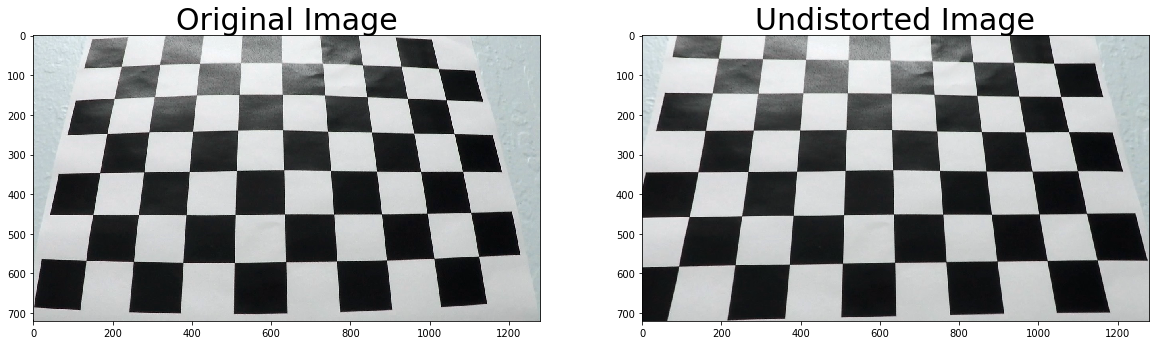

In [3]:
# Undistort image
image_undistorted = cv2.undistort(image, mtx, dist, None, mtx)

# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(image_undistorted)
ax2.set_title('Undistorted Image', fontsize=30)

f.savefig("examples/distorted_undistorted.jpg")

In [4]:
def calc_transform_matrix_chessboard(image_undistorted, n_x, n_y, mtx, dist, offset):
    '''
    This function takes the undistorted color image of a chessboard for which the perspective transform matrix 
    is to be calculated. The number of chessboard corners in x and y direction must be counted manually and 
    passed to the function alongside the camera's distortion coefficients dist and the target offset of the 
    corners from the image edges in topview image. "Chessboard corners" are only points where two black and two 
    white squares intersect.
    The function returns the perspective transform matrix.
    '''
    # Grayscale image
    image_grayscale = cv2.cvtColor(image_undistorted, cv2.COLOR_BGR2GRAY)

    # Find chessboard corners
    # Function returns non-zero value ret if all corners are found
    ret, corners = cv2.findChessboardCorners(image_grayscale, (n_x, n_y), None)
    cv2.drawChessboardCorners(image_undistorted, (n_x,n_y), corners, ret)

    if ret == True:
        # Define source and destination coordinates
        src = np.float32([corners[0], corners[n_x-1], corners[-1], corners[-n_x]])

        dst = np.float32([[offset, offset], [image_size[0]-offset, offset], [image_size[0]-offset, image_size[1]-offset], [offset, image_size[1]-offset]])

        # Get transform matrix M
        M = cv2.getPerspectiveTransform(src, dst)
        return M
    else:
        print("Not all chessboard corners were found. Try using a different image for obtaining the transform matrix!")

# Offset of corners from image edges in unwarped image
offset = 100

# Calculate transform
M = calc_transform_matrix_chessboard(image_undistorted, n_x, n_y, mtx, dist, offset)
image_topview = cv2.warpPerspective(image_undistorted, M, image_size)

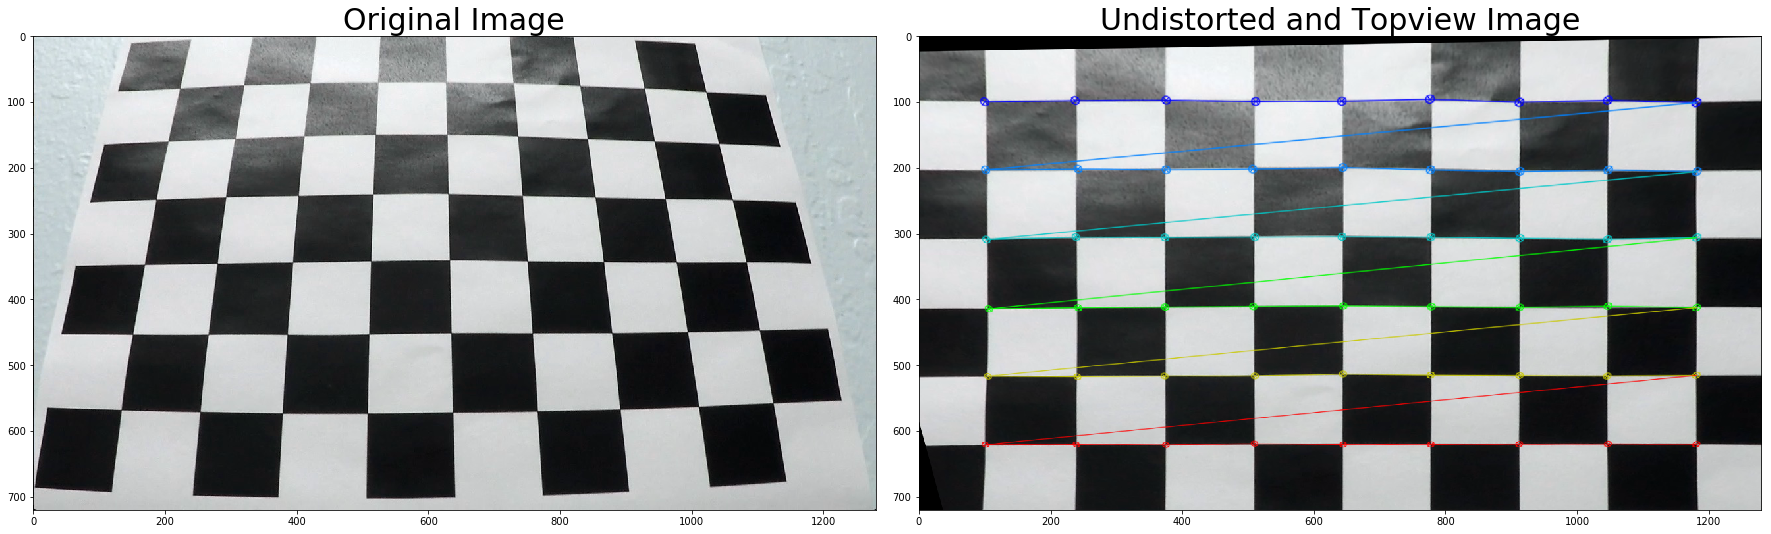

In [5]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(image_topview)
ax2.set_title('Undistorted and Topview Image', fontsize=30)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

### Pipeline (test images)

#### 1. Apply a distortion correction to raw images

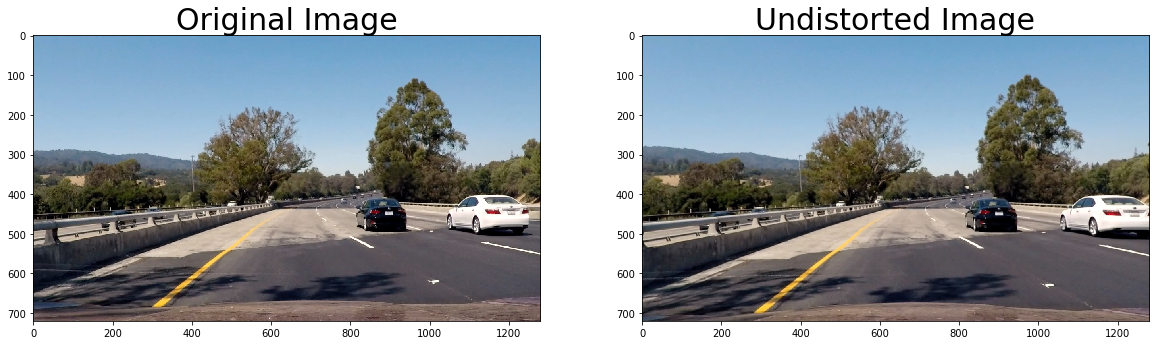

In [6]:
image = mpimg.imread('test_images/test4.jpg')

# Read in the saved camera matrix and distortion coefficients
dist_pickle = pickle.load(open("camera_cal/dist_pickle.p", "rb"))
mtx = dist_pickle["mtx"]
dist = dist_pickle["dist"]
image_undistorted = cv2.undistort(image, mtx, dist, None, mtx)

# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(image_undistorted)
ax2.set_title('Undistorted Image', fontsize=30)

f.savefig("examples/pipeline_distorted_undistorted.png")

#### 2. Use color transforms, gradients, etc. to create a thresholded binary image

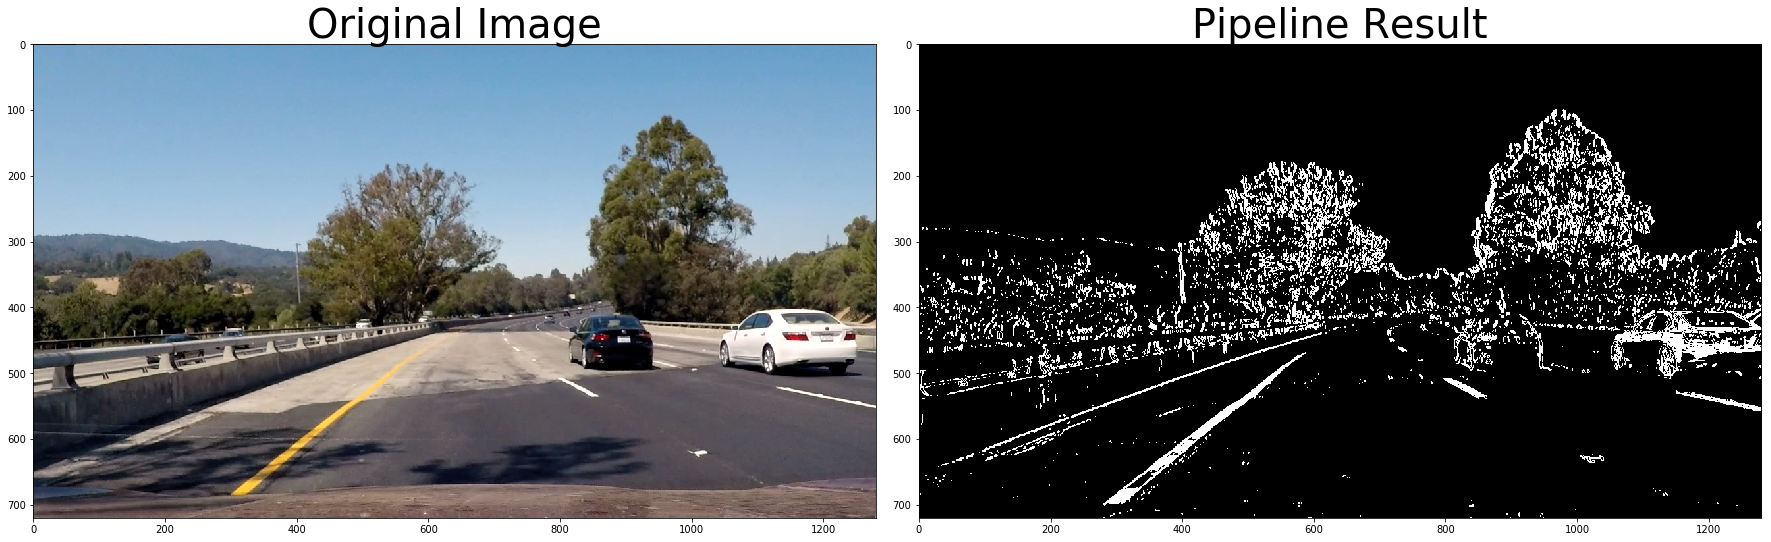

In [7]:
def abs_threshold(image, orient='x', sobel_kernel=3, thresh_min=0, thresh_max=255):
    '''
    This function takes a single channel image (e.g. grayscale), applies the Sobel operator in orient='x' or 
    orient='y' orientation with the the specified kernel, then takes the absolute value, scales the image back to 
    (0,255) and applies the specified threshold.
    '''
    # Convert to grayscale
    sobel = np.copy(image)*0

    # Take the derivative in x or y given orient='x' or 'y'
    if orient == 'x':
        sobel = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    else:
        sobel = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    
    # Take the absolute value of the derivative or gradient
    abs_sobel = np.absolute(sobel)
    
    # Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scaled_sobel = np.uint8(255 * abs_sobel / np.max(abs_sobel))

    # Create a binary mask where thresh_min and thresh_max are met
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
    
    return binary_output

def mag_threshold(image, sobel_kernel=3, mag_thresh=(0, 255)):
    '''
    This function applies the Sobel operator in x and y orientation separately with the the specified kernel, then 
    calculates the magnitude using np.sqrt(), scales the image back to (0,255) and applies the specified threshold.
    '''
    # Convert to grayscale
    image_grayscale = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    
    # Take the gradient in x and y separately
    sobel_x = cv2.Sobel(image_grayscale, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobel_y = cv2.Sobel(image_grayscale, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    
    # Calculate the magnitude
    sobel_magnitude = np.sqrt(sobel_x**2 + sobel_y**2)
    
    # Scale to 8-bit (0 - 255) and convert to type = np.uint8
    scale_factor = 255 / np.max(sobel_magnitude)
    
    scaled_sobel_magnitude = np.uint8(sobel_magnitude * scale_factor)

    # Create a binary mask where mag thresholds are met
    binary_output = np.zeros_like(scaled_sobel_magnitude)
    binary_output[(scaled_sobel_magnitude >= mag_thresh[0]) & (scaled_sobel_magnitude <= mag_thresh[1])] = 1
    
    return binary_output

def dir_threshold(image, sobel_kernel=3, thresh=(0, np.pi/2)):
    '''
    This function applies the Sobel operator in x and y orientation separately with the the specified kernel, then 
    calculates the direction of the gradient using np.arctan2() and applies the specified threshold.
    '''
    # Convert to grayscale
    image_grayscale = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    
    # Take the gradient in x and y separately
    sobel_x = cv2.Sobel(image_grayscale, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobel_y = cv2.Sobel(image_grayscale, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    
    # Take the absolute value of the x and y gradients
    abs_sobel_x = np.absolute(sobel_x)
    abs_sobel_y = np.absolute(sobel_y)
    
    # Calculate the direction of the gradient 
    sobel_direction = np.arctan2(abs_sobel_y, abs_sobel_x)
    
    # Create a binary mask where direction thresholds are met
    binary_output = np.zeros_like(sobel_direction)
    binary_output[(sobel_direction >= thresh[0]) & (sobel_direction <= thresh[1])] = 1
    
    return binary_output

def apply_thresholds(image, S_thresh, L_thresh, sobel_x_L_thresh, sobel_kernel=3):
    # Convert to HLS color space
    image_hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    
    # Get single color channels
    image_S = image_hls[:,:,2]
    image_L = image_hls[:,:,1]
    image_H = image_hls[:,:,0]
    
    sobel_x_L_binary = abs_threshold(image_L, orient='x', sobel_kernel=ksize, thresh_min=sobel_x_L_thresh[0], thresh_max=sobel_x_L_thresh[1])

    # Threshold color channel
    S_binary = np.zeros_like(image_S)
    S_binary[(image_S >= S_thresh[0]) & (image_S <= S_thresh[1])] = 1
    
    # Threshold L channel
    L_binary = np.zeros_like(image_S)
    L_binary[(image_L >= L_thresh[0]) & (image_L <= L_thresh[1])] = 1

    # Add all binary images into a single binary image
    image_binary = np.zeros_like(image_S)
    # image_binary[(sobel_x_L_binary == 1) | (S_binary == 1)] = 1
    image_binary[(sobel_x_L_binary == 1) | (S_binary == 1) & (L_binary == 1)] = 1
    
    # plt.imshow(image_binary, cmap='gray')
    
    return image_binary

# Parameters
ksize = 5
S_thresh=(170, 255)
L_thresh=(20, 255)
sobel_x_L_thresh=(20, 100)

image_binary = apply_thresholds(image_undistorted, S_thresh, L_thresh, sobel_x_L_thresh, sobel_kernel=5)

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(image)
ax1.set_title('Original Image', fontsize=40)

ax2.imshow(image_binary, cmap='gray')
ax2.set_title('Pipeline Result', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

f.savefig("examples/pipeline_thresholding.png")

#### 3a. Apply a perspective transform to rectify color image ("birds-eye view")

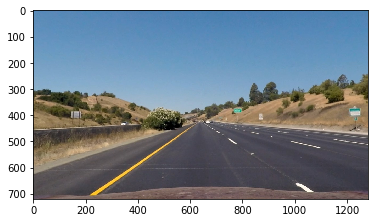

In [8]:
image = mpimg.imread('test_images/straight_lines1.jpg')
# image = mpimg.imread('test_images/test4.jpg')
image_undistorted = cv2.undistort(image, mtx, dist, None, mtx)

image_size = (image_undistorted.shape[1], image_undistorted.shape[0]) # (x_size, y_size)
x_size = image_size[0]
y_size = image_size[1]

plt.imshow(image_undistorted)

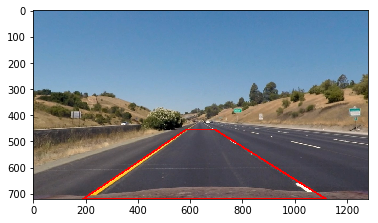

In [9]:
# Corners manually obtained from looking at picture
# bottom_left, bottom_right, top_left, top_right
corners = [(190, y_size), (1120, y_size), (585, 455), (695, 455)]

image_undistorted_lines = np.copy(image_undistorted)

# Draw lines corresponding to source points
cv2.line(image_undistorted_lines, corners[0], corners[1], (255,0,0), 5)
cv2.line(image_undistorted_lines, corners[2], corners[3], (255,0,0), 5)
cv2.line(image_undistorted_lines, corners[0], corners[2], (255,0,0), 5)
cv2.line(image_undistorted_lines, corners[1], corners[3], (255,0,0), 5)

plt.imshow(image_undistorted_lines)

plt.savefig("examples/destination_corners.png")

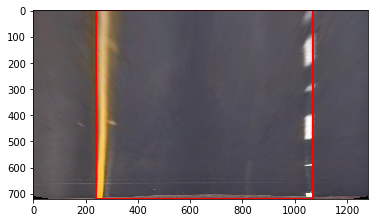

In [10]:
def calc_transform_matrix(image_binary, n_x, n_y, mtx, dist, corners, offset):
    '''
    This function takes the undistorted color image for which the perspective transform matrix is to be 
    calculated. The number of corners in x and y direction must be counted manually and passed to the function 
    alongside the camera's distortion coefficients dist and the target offset of the corners from the image edges 
    in topview image.
    The function returns the perspective transform matrix.
    '''
    # Define source and destination coordinates
    src = np.float32([corners[0], corners[1], corners[2], corners[3]])

    # bottom_left, bottom_right, top_left, top_right
    dst = np.float32([(corners[0][0]+offset, corners[0][1]), (corners[1][0]-offset, corners[1][1]), (corners[0][0]+offset, 0), (corners[1][0]-offset, 0)])

    # Get transform matrix M
    M = cv2.getPerspectiveTransform(src, dst)
    return M

offset = 50

# Calculate transform
M = calc_transform_matrix(image_undistorted, 9, 6, mtx, dist, corners, offset)

# Warp image
image_topview = cv2.warpPerspective(image_undistorted, M, image_size)

# Draw lines corresponding to destination points
cv2.line(image_topview, (corners[0][0]+offset, corners[0][1]), (corners[1][0]-offset, corners[1][1]), (255,0,0), 5)
cv2.line(image_topview, (corners[0][0]+offset, 0), (corners[1][0]-offset, 0), (255,0,0), 5)
cv2.line(image_topview, (corners[0][0]+offset, corners[0][1]), (corners[0][0]+offset, 0), (255,0,0), 5)
cv2.line(image_topview, (corners[1][0]-offset, corners[1][1]), (corners[1][0]-offset, 0), (255,0,0), 5)

plt.imshow(image_topview)

plt.savefig("examples/pipeline_warped.png")

#### 3b. Apply a perspective transform to rectify binary image

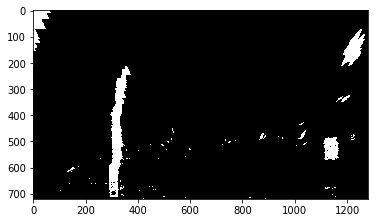

In [11]:
# Warp image
image_binary_topview = cv2.warpPerspective(image_binary, M, image_size)

plt.imshow(image_binary_topview, cmap='gray')

plt.savefig("examples/test_image.png")

#### 4. Detect lane pixels and fit to find the lane boundary

In [12]:
def calc_histogram(image_binary_topview, plot=0):    
    # Grab only the bottom half of the image
    bottom_half = image_binary_topview[image_binary_topview.shape[0]//2:,:]

    # Sum across image pixels vertically
    histogram = np.sum(bottom_half, axis=0)
    
    if plot:
        plt.plot(histogram)
    
    return histogram

In [13]:
def fit_polynomial(image_binary_topview, x_left, y_left, x_right, y_right, m_per_pix_x=3.7/700, m_per_pix_y=30/720, draw=0):
    # Generate y values for plotting
    y_plot = np.linspace(0, image_binary_topview.shape[0] - 1, image_binary_topview.shape[0])
    
    # Fit a second order polynomial to each line
    # Fit for f(y), rather than f(x), because the lane lines in the warped image are near vertical 
    # and may have the same x value for more than one y value.
    left_fit = np.polyfit(y_left, x_left, 2)
    right_fit = np.polyfit(y_right, x_right, 2)
    
    left_fit_real = np.polyfit(y_left * m_per_pix_y, x_left * m_per_pix_x, 2)
    right_fit_real = np.polyfit(y_right * m_per_pix_y, x_right * m_per_pix_x, 2)
    
    # Calculate both polynomials using y_plot, left_fit and right_fit
    try:
        x_left_fit = left_fit[0] * y_plot**2 + left_fit[1] * y_plot + left_fit[2]
        x_right_fit = right_fit[0] * y_plot**2 + right_fit[1] * y_plot + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        x_left_fit = 1 * y_plot**2 + 1 * y_plot
        x_right_fit = 1 * y_plot**2 + 1 * y_plot
        
    # Create an output image to draw on and visualize the result
    image_output = np.dstack((image_binary_topview, image_binary_topview, image_binary_topview))
    
    if draw:
        # Visualization
        # Colors in the left and right lane regions
        image_output[y_left, x_left] = [255, 0, 0]
        image_output[y_right, x_right] = [0, 0, 255]
        
        # Blank image for visualization of lane
        blank_image = np.zeros_like(image_output)

        # Combine the result with the original image
        image_visualization = cv2.addWeighted(image_output, 1, blank_image, 0.5, 0)

    return left_fit, right_fit, left_fit_real, right_fit_real, image_visualization

In [14]:
def find_lane_pixels(image_binary_topview, draw=0):
    # Take a histogram of the bottom half of the image
    histogram = calc_histogram(image_binary_topview)
    
    # Create an output image to draw on and visualize the result
    image_visualization = np.dstack((image_binary_topview, image_binary_topview, image_binary_topview))
    
    # Find the peak of the left and right halves of the histogram
    # These will be the starting points for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    x_left_base = np.argmax(histogram[:midpoint]) # histogram peak in left half (x coordinate)
    x_right_base = np.argmax(histogram[midpoint:]) + midpoint # histogram peak in right half (x coordinate)

    # Hyperparameters
    # Choose the number of sliding windows
    n_windows = 9
    
    # Set the width of the windows +/- margin
    margin = 100
    
    # Set minimum number of pixels found to recenter window
    min_pixels = 50

    # Set height of windows - image shape divided by number of windows 
    height_window = np.int(image_binary_topview.shape[0]//n_windows)
    
    # Identify x and y positions of all nonzero pixels in the image
    # np.nonzero returns a tuple of arrays containing the indices of the elements that are non-zero
    nonzero = image_binary_topview.nonzero()
    
    # Save array containing indices of non-zero x elements (y elements)
    nonzero_y = np.array(nonzero[0])
    nonzero_x = np.array(nonzero[1])
    
    # Current positions to be updated later for each window in n_windows
    x_left_current = x_left_base
    x_right_current = x_right_base

    # Create empty lists to receive left and right line pixel indices
    indices_left_line = []
    indices_right_line = []

    # Step through the windows one by one
    for window in range(n_windows):
        # Identify window boundaries in x and y (and right and left)
        y_low = image_binary_topview.shape[0] - (window + 1) * height_window # image_binary_topview.shape[0] is y coordinate!
        y_high = image_binary_topview.shape[0] - window * height_window
        
        # Find the four below boundaries of the window
        x_left_low = x_left_current - margin  
        x_left_high = x_left_current + margin
        x_right_low = x_right_current - margin
        x_right_high = x_right_current + margin
        
        if draw:
            # Draw the windows on the visualization image
            cv2.rectangle(image_visualization, (x_left_low,y_low), (x_left_high,y_high), (0,255,0), 2) 
            cv2.rectangle(image_visualization, (x_right_low,y_low), (x_right_high,y_high), (0,255,0), 2) 
        
        # Identify the nonzero pixels in x and y within the window
        indices_window_y = ((nonzero_y >= y_low) & (nonzero_y < y_high))
        indices_window_left_x = ((nonzero_x >= x_left_low) & (nonzero_x < x_left_high))
        indices_window_right_x = ((nonzero_x >= x_right_low) & (nonzero_x < x_right_high))
        
        good_indices_left = (indices_window_y & indices_window_left_x).nonzero()[0]
        good_indices_right = (indices_window_y & indices_window_right_x).nonzero()[0]
        
        # Append these indices to the lists
        indices_left_line.append(good_indices_left)
        indices_right_line.append(good_indices_right)
        
        # If more than min_pixels are found, re-center the next window
        if len(good_indices_left) > min_pixels:
            x_left_current = np.int(np.mean(nonzero_x[good_indices_left]))
        
        if len(good_indices_right) > min_pixels:
            x_right_current = np.int(np.mean(nonzero_x[good_indices_right]))

    # Concatenate the arrays of indices
    try:
        indices_left_line = np.concatenate(indices_left_line)
        indices_right_line = np.concatenate(indices_right_line)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    x_left = nonzero_x[indices_left_line]
    y_left = nonzero_y[indices_left_line] 
    x_right = nonzero_x[indices_right_line]
    y_right = nonzero_y[indices_right_line]
    
    if draw:
        image_visualization[y_left, x_left] = [255, 0, 0]
        image_visualization[y_right, x_right] = [0, 0, 255]

    return x_left, y_left, x_right, y_right, image_visualization

In [15]:
def search_around_polynomial(image_binary_topview, left_fit_previous, right_fit_previous, margin=50, draw=0):
    # Grab activated pixels
    nonzero = image_binary_topview.nonzero()
    nonzero_y = np.array(nonzero[0])
    nonzero_x = np.array(nonzero[1])
    
    # Set the area of search based on activated x-values within the +/- margin of the polynomial function
    # f(y) = x, find area where
    # x > f(y - margin) & x < f(y + margin)
    indices_left_line = ((nonzero_x > (left_fit_previous[0] * (nonzero_y**2) + left_fit_previous[1] * nonzero_y + left_fit_previous[2] - margin)) 
                         & (nonzero_x < (left_fit_previous[0] * (nonzero_y**2) + left_fit_previous[1] * nonzero_y + left_fit_previous[2] + margin)))
    indices_right_line = ((nonzero_x > (right_fit_previous[0] * (nonzero_y**2) + right_fit_previous[1] * nonzero_y + right_fit_previous[2] - margin)) 
                         & (nonzero_x < (right_fit_previous[0] * (nonzero_y**2) + right_fit_previous[1] * nonzero_y + right_fit_previous[2] + margin)))
    
    # Again, extract left and right line pixel positions
    x_left = nonzero_x[indices_left_line]
    y_left = nonzero_y[indices_left_line] 
    x_right = nonzero_x[indices_right_line]
    y_right = nonzero_y[indices_right_line]
    
    # Create an image to draw on and an image to show the selection window
    image_visualization = np.dstack((image_binary_topview, image_binary_topview, image_binary_topview))*255
    
    if draw:
    
        # Create an image to draw on and an image to show the selection window
        image_output = np.copy(image_visualization)
    
        # Generate x and y values for plotting
        y_plot = np.linspace(0, image_binary_topview.shape[0] - 1, image_binary_topview.shape[0])

        # Calculate both polynomials using y_plot, left_fit and right_fit
        try:
            x_left_fit_previous = left_fit_previous[0] * y_plot**2 + left_fit_previous[1] * y_plot + left_fit_previous[2]
            x_right_fit_previous = right_fit_previous[0] * y_plot**2 + right_fit_previous[1] * y_plot + right_fit_previous[2]
        except TypeError:
            # Avoids an error if `left` and `right_fit` are still none or incorrect
            print('The function failed to fit a line!')
            x_left_fit_previous = 1 * y_plot**2 + 1 * y_plot
            x_right_fit_previous = 1 * y_plot**2 + 1 * y_plot

        # Visualization
        blank_image = np.zeros_like(image_output)
        
        # Color in left and right line pixels
        image_output[nonzero_y[indices_left_line], nonzero_x[indices_left_line]] = [255, 0, 0]
        image_output[nonzero_y[indices_right_line], nonzero_x[indices_right_line]] = [0, 0, 255]

        # Generate a polygon to illustrate the search window area
        # And recast the x and y points into usable format for cv2.fillPoly()
        left_line_window_1 = np.array([np.transpose(np.vstack([x_left_fit_previous - margin, y_plot]))])
        left_line_window_2 = np.array([np.flipud(np.transpose(np.vstack([x_left_fit_previous + margin, y_plot])))])
        left_line_pts = np.hstack((left_line_window_1, left_line_window_2))
        right_line_window1 = np.array([np.transpose(np.vstack([x_right_fit_previous - margin, y_plot]))])
        right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([x_right_fit_previous + margin, y_plot])))])
        right_line_pts = np.hstack((right_line_window1, right_line_window2))

        # Draw the lane onto the warped blank image
        cv2.fillPoly(blank_image, np.int_([left_line_pts]), (0,255, 0))
        cv2.fillPoly(blank_image, np.int_([right_line_pts]), (0,255, 0))
        image_visualization = cv2.addWeighted(image_output, 1, blank_image, 0.3, 0)

        # Plot the polynomial lines onto the image
        plt.plot(x_left_fit_previous, y_plot, color='yellow')
        plt.plot(x_right_fit_previous, y_plot, color='yellow')
    
    return x_left, y_left, x_right, y_right, image_visualization

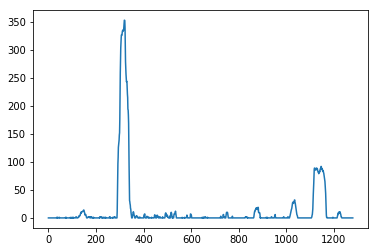

In [16]:
histogram = calc_histogram(image_binary_topview, plot=1)

plt.savefig("examples/histogram.png")

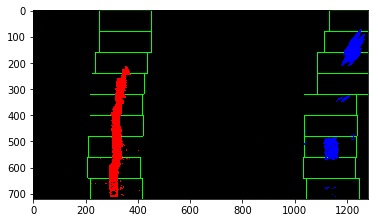

In [17]:
x_left, y_left, x_right, y_right, image_visualization = find_lane_pixels(image_binary_topview, draw=1)

plt.imshow(image_visualization)

plt.savefig("examples/sliding_windows.png")

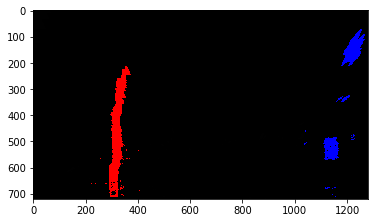

In [18]:
left_fit, right_fit, left_fit_real, right_fit_real, image_visualization = fit_polynomial(image_binary_topview, x_left, y_left, x_right, y_right, draw=1)

plt.imshow(image_visualization)

plt.savefig("examples/lane-line_pixels_from_scratch.png")

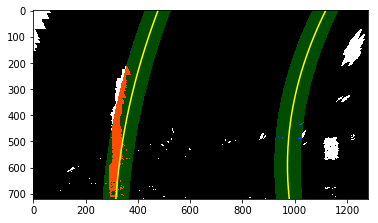

In [19]:
# Run image through the pipeline using the fit from the previous frame
x_left, y_left, x_right, y_right, image_visualization = search_around_polynomial(image_binary_topview, np.array([ 2.13935315e-04, -3.77507980e-01,  4.76902175e+02]), np.array([4.17622148e-04, -4.93848953e-01,  1.11806170e+03]), draw=1)

# View your output
plt.imshow(image_visualization)

plt.savefig("examples/test_image_with_previous_fit.png")

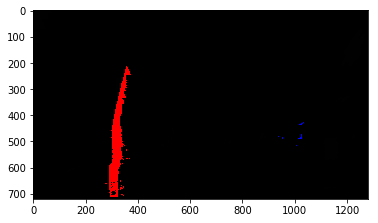

In [20]:
left_fit, right_fit, left_fit_real, right_fit_real, image_visualization = fit_polynomial(image_binary_topview, x_left, y_left, x_right, y_right, draw=1)

# View your output
plt.imshow(image_visualization)

plt.savefig("examples/lane-line_pixels_from_previous_fit.png")

#### 5. Determine the curvature of the lane and vehicle position with respect to center

See functions `measure_curvature_real()` and `calculate_line_base_position()` below.

#### 6. Warp the detected lane boundaries back onto the original image

In [21]:
def to_original_image(image_undistorted, image_visualization, M):
    # Invert matrix
    M_inv = np.linalg.inv(M)

    # Warp image_visualization back to original image space using inverse perspective matrix (Minv)
    image_visualization_dewarped = cv2.warpPerspective(image_visualization, M_inv, (image.shape[1], image.shape[0]))
    
    # Combine the result with the original image
    result = cv2.addWeighted(image_undistorted, 1, image_visualization_dewarped, 0.3, 0)
    
    result_with_lines = cv2.add(result, image_visualization_dewarped)
    
    return result_with_lines

#### 7. Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position

See function `process_image()` below.

### Pipeline (video)

In [22]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML
from collections import deque

In [23]:
# Parameters
max_history = 30 # the last max_history frames are used for averaging
n_smoothing = 10

# Get camera calibration data
dist_pickle = pickle.load(open("camera_cal/dist_pickle.p", "rb"))
mtx = dist_pickle["mtx"]
dist = dist_pickle["dist"]

# Parameters
ksize = 5
S_thresh=(170, 255)
L_thresh=(20, 255)
sobel_x_L_thresh=(20, 100)

debug = False
debug_draw = False

image_id = 0

font = cv2.FONT_HERSHEY_SIMPLEX
bottom_left_corner_top = (50,50)
bottom_left_corner_bottom = (50,100)
font_scale = 1
font_color = (255,255,255)
line_type = 2

# Define conversions in x and y from pixels space to meters
m_per_pix_y = 30/720 # meters per pixel in y dimension
m_per_pix_x = 3.7/700 # meters per pixel in x dimension

In [24]:
class Line():
    id = 0 # Static variable for debugging purposes
    
    def __init__(self):
        # Increment and set id
        Line.id += 1
        # Was the line detected in the last iteration?
        self.detected_new = False     
        # Polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        # Polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        # Radius of curvature of the line in some units
        self.radius_of_curvature = None 
        # Distance in meters of vehicle center from the line
        self.line_base_position = None 
        # x values for detected line pixels
        self.all_x = None  
        # y values for detected line pixels
        self.all_y = None

In [25]:
def measure_curvature_real(left_fit_real, right_fit_real, y_eval):
    '''
    Calculates the curvature of polynomial functions in meters.
    '''    
    y_real = y_eval * m_per_pix_y
    
    # Calculation of R_curve (radius of curvature)
    curve_radius_left = (1 + (2 * left_fit_real[0] * y_real + left_fit_real[1])**2)**(3.0/2) / (2 * left_fit_real[0])
    curve_radius_right = (1 + (2 * right_fit_real[0] * y_real + right_fit_real[1])**2)**(3.0/2) / (2 * right_fit_real[0])
    
    return curve_radius_left, curve_radius_right

In [26]:
def check_horizontal_line_distance_at(y, left_fit, right_fit, distance=800, margin=25):
    x_left = left_fit[0] * y**2 + left_fit[1] * y + left_fit[2] 
    x_right = right_fit[0] * y**2 + right_fit[1] * y + right_fit[2] 
    diff = x_right - x_left
    return (distance-margin <= diff <= distance+margin), diff

In [27]:
def check_parallel(left_fit, right_fit, y_max, distance=800, margin=50):
    x_left_min = left_fit[2]
    x_left_max = left_fit[0] * y_max**2 + left_fit[1] * y_max + left_fit[2]
    
    x_right_min = right_fit[2]
    x_right_max = right_fit[0] * y_max**2 + right_fit[1] * y_max + right_fit[2]
    
    diff_min = x_right_min - x_left_min
    diff_max = x_right_max - x_left_max
    
    return (distance-margin <= diff_min <= distance+margin) & (distance-margin <= diff_max <= distance+margin)

In [28]:
def check_curvature(left_curvature, right_curvature, margin=500):
    diff = np.abs(left_curvature) - np.abs(right_curvature)
    return (np.abs(diff) <= margin)

In [29]:
def calculate_line_base_position(x, x_max, y_max):
    # Distance in meters of vehicle center from line
    # If diff > 0: Left line, if diff < 0: Right line
    diff = x_max/2 - x
    result = np.average(diff) * m_per_pix_x
    return result

In [30]:
def process_image(image):
    image_id = Line.id
    
    image_size = (image.shape[1], image.shape[0]) # (x_size, y_size)
    x_max = image_size[0]
    y_max = image_size[1]
    
    # 1. Undistort using camera calibration parameters mtx and dist
    image_undistorted = cv2.undistort(image, mtx, dist, None, mtx)
    
    # 2. Apply thresholds
    image_undistorted_binary = apply_thresholds(image_undistorted, S_thresh, L_thresh, sobel_x_L_thresh, sobel_kernel=5)
    
    # 3. Warp image using transform matrix M
    image_binary_topview = cv2.warpPerspective(image_undistorted_binary, M, image_size)
    
    ### Create new Line objects for current frame ###
    line_left = Line()
    line_right = Line()
    
    line_left_previous = []
    line_right_previous = []
    
    # 4. Detect lane pixels and fit to find lane boundary
    if (len(lines_history) <= 1): # There are no lines in the history or the last lines were bad
        
        # 4.1 Calculate fit data from scratch
        line_left.all_x, line_left.all_y, line_right.all_x, line_right.all_y, image_visualization = find_lane_pixels(image_binary_topview, draw=0)
    
        if debug:
            print(image_id, ": History empty. Used sliding window search.")
        
    else: # There are some lines in the history
        
        # Grab the fit from the previous one
        line_left_previous = lines_history[-1][0]
        line_right_previous = lines_history[-1][1]
        
        # 4.1. Run image through pipeline using fit from previous frame
        line_left.all_x, line_left.all_y, line_right.all_x, line_right.all_y, image_visualization = search_around_polynomial(image_binary_topview, line_left_previous.current_fit, line_right_previous.current_fit, margin=150, draw=0)
        
        if debug:
            print(image_id, ": Searched around fit from previous frame.")
            
    # 4.2 Fit polynomial to the pixels that were found
    line_left.current_fit, line_right.current_fit, line_left.current_fit_real, line_right.current_fit_real, image_visualization = fit_polynomial(image_binary_topview, line_left.all_x, line_left.all_y, line_right.all_x, line_right.all_y, draw=1)
    
    # 5. Calculate radius of curvature of the line in m
    curvature = measure_curvature_real(line_left.current_fit_real, line_right.current_fit_real, y_max)
    line_left.radius_of_curvature = curvature[0]
    line_right.radius_of_curvature = curvature[1]
    curvature_median = np.abs(np.round((np.average(curvature)), decimals=2))
    
    # Distance in meters of vehicle center from the line
    line_left.line_base_position = calculate_line_base_position(line_left.all_x, x_max, y_max)
    line_right.line_base_position = calculate_line_base_position(line_right.all_x, x_max, y_max)
    
    # 6. Calculate offset
    offset_center = np.abs(np.round(np.abs(line_left.line_base_position) - np.abs(line_right.line_base_position), decimals=2))
    offset_direction = "right"
    if (offset_center < 0):
        offset_direction = "left"
    
    ### 7. Do some sanity checks ###
    # Checking that both lines have similar curvature
    # Checking that both lines are separated by approximately the right distance horizontally
    # Checking that both lines are roughly parallel
    
    # Pass distance, margin in pixels
    # Pass the x coordinates at the bottom of the picture (y=y_max)
    # Don't check at the very bottom of the image since there are never lines due to the front of the 
    # car showing up in the images/videos
    distance_good, diff = check_horizontal_line_distance_at(y_max-50, line_left.current_fit, line_right.current_fit, margin=100)
    # curvature_good = check_curvature(line_left.radius_of_curvature, line_right.radius_of_curvature, margin=5000)
    curvature_good = True
    parallel_good = check_parallel(line_left.current_fit, line_right.current_fit, y_max-50, margin=100)
    
    if distance_good & parallel_good & curvature_good: # Current frame is good
        # Add newly detected lines to history
        lines_history.append([line_left, line_right])
        
        if debug:
            print(image_id, ": Good frame detected.")
        
        if debug_draw:
            f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
            f.tight_layout()
            ax1.imshow(image_visualization, cmap='gray')
            ax1.set_title('Topview', fontsize=40)
            ax2.imshow(image_binary_topview, cmap='gray')
            ax2.set_title('Normal', fontsize=40)
            plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    
    else: # Current frame is bad
        if debug:
            print(image_id, ": Bad frame detected, because: ")
            
            if not distance_good:
                print("- horizontal distance = ", diff, " not plausible")
            if not curvature_good:
                print("- curvature = ", [line_left.radius_of_curvature, line_right.radius_of_curvature], " not plausible")
            if not parallel_good:
                print("- lines not parallel")
        
        if (len(lines_history) > 1):
            lines_history.popleft() # Remove oldest fit from lines_history
            
            if debug:
                print("Removed oldest frame from history.")
            
        elif (len(lines_history) == 1): 
            pass # Never remove the last element from lines_history
        
    ### 8. Smoothing ###
    if (not lines_history): # There are no lines in the history
        # best_fit: Save current_fit as best_fit since there is no history available
        line_left.best_fit = line_left.current_fit
        line_right.best_fit = line_right.current_fit
    
    else: # There is at least one set of good lines in the history
        fits_left_smoothing = []
        fits_right_smoothing = []
        
        # best_fit: Average polynomial coefficients over last n_smoothing frames in lines_history
        for i in range(1,min(n_smoothing, len(lines_history)) + 1):
            fits_left_smoothing.append((lines_history[-(i)][0]).current_fit)
            fits_right_smoothing.append((lines_history[-(i)][1]).current_fit)
    
        line_left.best_fit = np.average(fits_left_smoothing, axis=0)
        line_right.best_fit = np.average(fits_right_smoothing, axis=0)
    
    ### 9. Draw lane onto image_visualization ###
    # Generate x and y values for plotting
    y_plot = np.linspace(0, image_visualization.shape[0] - 1, image_visualization.shape[0])
    
    # Calculate both polynomials using y_plot, left_fit and right_fit
    x_left_fit = line_left.best_fit[0] * y_plot**2 + line_left.best_fit[1] * y_plot + line_left.best_fit[2]
    x_right_fit = line_right.best_fit[0] * y_plot**2 + line_right.best_fit[1] * y_plot + line_right.best_fit[2]

    # Recast the x and y points into usable format for cv2.fillPoly()
    left_line_pts = np.array([np.transpose(np.vstack([x_left_fit, y_plot]))])
    right_line_pts = np.array([np.flipud(np.transpose(np.vstack([x_right_fit, y_plot])))])
    line_points = np.hstack((left_line_pts, right_line_pts))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(image_visualization, np.int_([line_points]), (0,255, 0))
    
    # 10. Warp back
    result = to_original_image(image_undistorted, image_visualization, M)
    
    # Write Curvature and offset
    cv2.putText(result,"Radius of curvature: " + str(curvature_median) + " m", bottom_left_corner_top, font, font_scale, font_color, line_type)
    cv2.putText(result,"Offset from lane center: " + str(offset_center) + " m to the " + offset_direction, bottom_left_corner_bottom, font, font_scale, font_color, line_type)
    
    if debug:
        print("--------------------")
        
    Line.id += 1
    
    # return image_visualization
    return result

In [31]:
lines_history = deque(maxlen=max_history)

white_output = 'output_videos/project_video.mp4'
# clip1 = VideoFileClip("project_video.mp4").subclip(17,19)
clip1 = VideoFileClip("project_video.mp4")

white_clip = clip1.fl_image(process_image) # NOTE: this function expects color images!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video output_videos/project_video.mp4
[MoviePy] Writing video output_videos/project_video.mp4


100%|█████████▉| 1260/1261 [02:49<00:00,  7.43it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_videos/project_video.mp4 

CPU times: user 5min 18s, sys: 26.7 s, total: 5min 45s
Wall time: 2min 50s


In [32]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))